<a href="https://colab.research.google.com/github/cristhianaalbert/Poresolution_code/blob/Machine-learning-models/ML_models_Na_selected_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

In [ ]:
!pip install requests==2.23.0 folium==0.2.1 imgaug==0.2.6 pycaret pandas shap 
from pycaret.utils import enable_colab
enable_colab()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pycaret.utils import check_metric
from pycaret.regression import *


In [ ]:
def count_alpha_error (a, alpha=0.1):

    '''Calculates the percentage of elements inside a +- alpha range around the true measured value of the ion;
     a = array with final predictions on unseen data;
     alpha = range of error
    '''
    error = a.Napredicted / a.Na                           #when we are dealing with log scale of ion, the analysis is still in absolute terms;
    count = error[((1-alpha) < error) & (error <(1+alpha))].size
    total = len(error)
    return count/total

Load dataset

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
#dataset = pd.read_csv(io.StringIO(uploaded['datasetMPKlogNa.csv'].decode('utf-8')))
dataset = pd.read_csv(io.StringIO(uploaded['database_Na_sel_1.csv'].decode('utf-8')),sep=',')

dataset.head()


Saving database_Na_sel_1.csv to database_Na_sel_1.csv


,Index,PC,SCM1,SCM1_type,SCM2,SCM2_type,PC_Na2O,PC_K2O,SCM1_SiO2,SCM1_Al2O3,SCM2_SiO2,SCM2_Al2O3,logNa,Na
0,9,0.53,0.47,3,0.00,0,0.07,0.65,34.87,11.62,0.0,0.0,1.754042,56.8
1,10,0.53,0.47,3,0.00,0,0.07,0.65,34.87,11.62,0.0,0.0,1.800717,63.2
2,19,0.53,0.38,3,0.09,5,0.07,0.65,34.87,11.62,2.0,0.8,1.745543,55.7
3,20,0.53,0.38,3,0.09,5,0.07,0.65,34.87,11.62,2.0,0.8,1.798029,62.8
4,29,0.53,0.38,3,0.09,7,0.07,0.65,34.87,11.62,100.0,0.0,1.775392,59.6


Visualize data

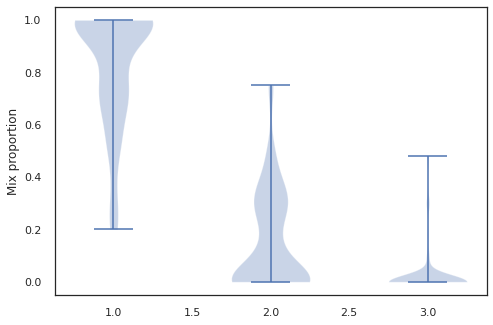

In [ ]:
## combine these different collections into a list
mixproportion = [dataset.PC, dataset.SCM1, dataset.SCM2]
#mixproportion = [dataset.waterbinder]
sns.set_theme(style="white")

# Create a figure instance
fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Mix proportion')
#ax.set_xlabel('Sample name') ['PC', 'SCM1', 'SCM2', 'w/b'] LEARN HOW TO SET THESE AXIS
# Create the boxplot
bp = ax.violinplot(mixproportion)
plt.show()

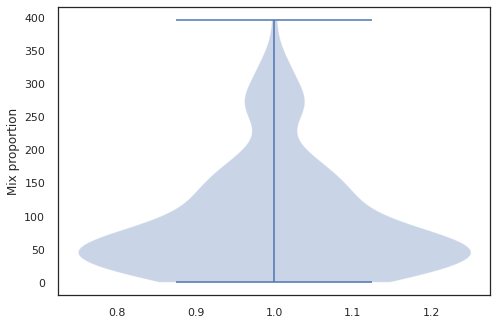

In [ ]:
## combine these different collections into a list
mixproportion = [10**dataset.logNa]
#mixproportion = [dataset.waterbinder]
sns.set_theme(style="white")

# Create a figure instance
fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Mix proportion')
#ax.set_xlabel('Sample name') ['PC', 'SCM1', 'SCM2', 'w/b'] LEARN HOW TO SET THESE AXIS
# Create the boxplot
bp = ax.violinplot(mixproportion)
plt.show()

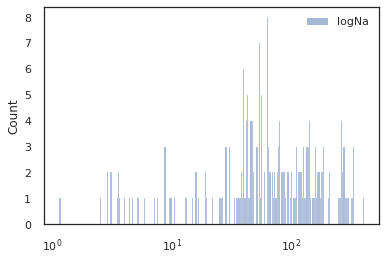

In [ ]:
fig, ax = plt.subplots()
sns.set_theme(style="white")
#sns.set_palette(sns.color_palette('Paired'))
mixproportion = [10**dataset.logNa]
sns.histplot(data=mixproportion, binwidth=0.01, log_scale=True,color='r', legend='Na')
#ax1.set_ylim(0, 30)
#plt.setp(ax, xticks=[10,100,1000])


In [ ]:
display(dataset.shape)
dataset.describe()


(210, 14)

,Index,PC,SCM1,SCM1_type,SCM2,SCM2_type,PC_Na2O,PC_K2O,SCM1_SiO2,SCM1_Al2O3,SCM2_SiO2,SCM2_Al2O3,logNa,Na
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,187.000000,183.000000,187.000000,192.000000,210.000000,210.000000,210.000000,210.000000
mean,414.842857,0.823190,0.155524,1.233333,0.021571,0.366667,0.237594,0.619344,31.608342,6.385458,4.013810,1.104286,1.749258,94.036667
std,267.207514,0.226039,0.191439,1.361758,0.080238,1.167270,0.182386,0.351067,37.973511,15.217129,15.564644,4.806239,0.522766,84.751890
min,9.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056766,1.100000
25%,177.250000,0.700000,0.000000,0.000000,0.000000,0.000000,0.130000,0.290000,0.000000,0.000000,0.000000,0.000000,1.595172,39.375000
50%,377.500000,0.940000,0.060000,1.000000,0.000000,0.000000,0.180000,0.540000,0.800000,0.000000,0.000000,0.000000,1.802634,63.500000
75%,606.000000,1.000000,0.300000,2.000000,0.000000,0.000000,0.410000,0.890000,49.015000,8.900000,0.000000,0.000000,2.130334,135.000000
max,999.000000,1.000000,0.750000,5.000000,0.480000,7.000000,0.900000,1.230000,98.700000,85.530000,100.000000,26.900000,2.597695,396.000000


In [ ]:
dataset.shape[1]

14

In [ ]:
SCM = dataset.SCM1 + dataset.SCM2
SCM_SiO2 = ( dataset.SCM1*dataset.SCM1_SiO2 + dataset.SCM2*dataset.SCM2_SiO2 ) / SCM
SCM_Al2O3 =( dataset.SCM1*dataset.SCM1_Al2O3 + dataset.SCM2*dataset.SCM2_Al2O3 ) / SCM
dataset.insert(dataset.shape[1],'SCM', SCM)
dataset.insert(dataset.shape[1],'SCM_SiO2', SCM_SiO2)
dataset.insert(dataset.shape[1],'SCM_Al2O3', SCM_Al2O3)
dataset.drop(['SCM1','SCM2','SCM1_type','SCM2_type','SCM1_SiO2','SCM1_Al2O3','SCM2_SiO2','SCM2_Al2O3'],axis=1,inplace=True)

# Modeling

In [ ]:
#defining initial parameters

model_list = ['rf','et']                        #models to be tested;
seed_list = [76,89,140,267,870]                       #seeds for separating data to train/test model and for final predictions; 
sid_list = [22,453,563,914]                         #seeds for session id on setup - I believe it defines how cross-validation groups are defined;
featsel_list = [1.0, 0.4, 0.3,0.2,0.15]         #feature_selection_threshold for setup - defines how many features will be considered in the model (train/test/prediction);
featsel_list = [1.0]         #feature_selection_threshold for setup - defines how many features will be considered in the model (train/test/prediction);
seed_list = [20, 76,89,140,267,310, 560, 771, 870, 952]                       #seeds for separating data to train/test model and for final predictions; 
sid_list = [22,120, 200, 420, 453, 563, 680, 739, 810, 914]                         #seeds for session id on setup - I believe it defines how cross-validation groups are defined;
kfold_list = [5]                            #numbers of folds for cross-validation - I didn't notice differences on the final results;


alpha1=0.1                                   #error range - used to evaluate +-10% error of prediction around the measured value;
alpha2=0.25                                  #error range - used to evaluate +-25% error of prediction around the measured value;
i=0                                          #initial index;

#tunemodel
tune_on = 1   # 1 to avoid tuning of hyperparameteres; 2 to allow tuning of hyperparameteres;
#These parameters are focused on decision tree methods;
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
tune_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
                        

totalsystems = len(model_list)*len(seed_list)*len(sid_list)*len(featsel_list)*len(kfold_list)*tune_on   #total number of systems considering all variables; times 2 because we have tuned models
totalcolumns = 10                                                                                 #depends on the statistic variables stored on the array "summary" (modelname, ..., R2, RMSE, alpha, etc)
summary = np.zeros((totalsystems, totalcolumns),dtype=object)                                     #array summary mentioned above;

#REMEMBER TO ALTER DEPENDING ON THE SIZE OF DATASET (HOW MANY VARIABLES IT HAS)
estimativefeat = round(int(2*dataset.shape[1]))                        #depends on the number of features in dataset - needs to be a little bit bigger to account for categorical features that are transformed (one hot encoding method)
mostimpfeat = 4                           #number of most important features to be analysed; 15 or 10 seems a reasonable number;


mostimpfeat_value = np.ndarray(shape=(totalsystems, mostimpfeat+1),dtype=object)                      #arrays to store most important features properties; plus 1 is for indexing modelname
mostimpfeat_name = np.zeros(shape=(totalsystems, mostimpfeat+1),dtype=object)
mostimpfeat_test = np.zeros(shape=(totalsystems, 2*mostimpfeat+1),dtype=object)

feat_summary=[]

mostimpfeat_value_full = np.zeros(shape=(totalsystems, estimativefeat),dtype=float)               #arrays to store all features properties
mostimpfeat_name_full = np.zeros(shape=(totalsystems, estimativefeat),dtype=object)
mostimpfeat_full_summary = []


#numfeat = ['SCM2_Amorphous','C1_T','C2_Age_days','C2_T','Pressure_MPa']
ignfeat = ['Index',"Na"]
numfeat = ['waterbinder','aggregatesbinder',
           'PC','SCM1','SCM2','PC_CaO','PC_SiO2','PC_Al2O3', 'PC_Fe2O3', 'PC_SO3', 'PC_MgO', 'PC_Na2O', 'PC_K2O', 
           'PC_TiO2', 'PC_P2O5', 'PC_MnO', 'PC_CO2','PC_LOI', 'PC_Amorphous', 'PC_C3S', 'PC_C2S', 'PC_C3A', 'PC_C4AF','PC_Blaine','PC_BET',
           'SCM1_CaO',	'SCM1_SiO2',	'SCM1_Al2O3',	'SCM1_Fe2O3',	'SCM1_SO3',	'SCM1_MgO',	'SCM1_Na2O',	'SCM1_K2O',	
           'SCM1_TiO2',	'SCM1_P2O5',	'SCM1_MnO',	'SCM1_CO2',	'SCM1_LOI','SCM1_Amorphous','SCM1_Blaine','SCM1_BET',
           'SCM2_CaO',	'SCM2_SiO2',	'SCM2_Al2O3',	'SCM2_Fe2O3',	'SCM2_SO3',	'SCM2_MgO',	'SCM2_Na2O',	'SCM2_K2O',	
           'SCM2_TiO2',	'SCM2_P2O5',	'SCM2_MnO',	'SCM2_CO2',	'SCM2_LOI','SCM2_Amorphous','SCM2_Blaine','SCM2_BET',
           'C1_Age_days','C1_RH','C1_T','C2_Age_days','C2_RH','C2_T','Final_age_days','Pressure_MPa']

numfeat = ['PC','SCM','PC_Na2O','PC_K2O','SCM_SiO2','SCM_Al2O3']


for modelname in model_list:                                #running for different models at same loop;
  for p in range(tune_on):                                                                                          #creating a normal and tuned version of the model  %TO AVOID HAVING TUNED MODELS, JUST PUT THE RANGE TO 1 INSTEAD OF 2

    for seed in seed_list:                                                                                      #running for different initial seeds for ramdom state - separation of data to train/test model and for final predictions;
      data = dataset.sample(frac=0.85, random_state=seed)
      data_unseen = dataset.drop(data.index)
      data.reset_index(drop=True, inplace=True)
      data_unseen.reset_index(drop=True, inplace=True)

      for sid in sid_list:                                                                                      #running for different seeds for session id on setup - I believe it defines how cross-validation groups are defined;
        for featsel in featsel_list:                                                                            #running different feature_selection_threshold for setup - defines how many features will be considered in the model (train/test/prediction)

          exp_ps = setup(data = data, target = 'logNa', session_id=sid, normalize = True, 
                        combine_rare_levels = True, rare_level_threshold = 0.05,
                        remove_outliers = True, log_experiment = True, experiment_name = 'poresolution',
                        numeric_features = numfeat, fold=5, ignore_features = ignfeat,
                        feature_selection = True, silent=True, verbose=False)

          for kfold in kfold_list:                          #running for different numbers of folds for cross-validation - I didn't notice differences on the final results;
            #model = create_model(modelname,fold=kfold, n_estimators=80,max_depth=10, verbose=False)
            model = create_model(modelname,n_estimators=80,max_depth=8,fold=kfold,verbose=False)


            if p == 0:                                      #normal model
              model = model           
              modelnameb = modelname

            if p == 1:                                      #tuned model
              model = tune_model(model,fold=kfold, optimize="RMSE", verbose=False)
              modelnameb = 'tuned_'+str(modelname)
            
            aaa=get_logs()

            final_model = finalize_model(model)
            unseen_predictions = predict_model(final_model, data=data_unseen, round=None)
            #test_predictions = predict_model(final_model, data=data_testprediction, round=None)

            #checking accuracy of predictions on unseen data - R2, RMSE, fraction of predictions within alpha error range;
            a = unseen_predictions
            alinear = pd.DataFrame([np.array(10**a.logNa), np.array(10**a.Label)]).T
            alinear.columns=["Na","Napredicted"]            
            R2 = check_metric(alinear.Na, alinear.Napredicted, 'R2' )     
            RMSE = check_metric(alinear.Na, alinear.Napredicted, 'RMSE' )
            erroralpha1 = count_alpha_error(alinear, alpha1)
            erroralpha2 = count_alpha_error(alinear, alpha2)

            nfeat = get_config('X_train').shape[1]           #number of features considered by model - depends on feature_selection_threshold;               

            summary[i,:] = ([modelnameb, seed, sid, kfold, featsel,nfeat, R2, RMSE, erroralpha1, erroralpha2])     #storing all these metrics for each system;


            featimp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(final_model.feature_importances_)})    #getting the feature importance scores for all systems;
            featimpsort = featimp.sort_values(by='Value', ascending=False)[:mostimpfeat]                                           #organizing feature importance scores in descending order of importance;
            
            feat1 = np.array(featimpsort)[0,0]            #1st to 5th most important feature -> to be displayed during evaluations -> important to checks during runs;
            feat2 = np.array(featimpsort)[1,0]
            feat3 = np.array(featimpsort)[2,0]
            feat4 = np.array(featimpsort)[3,0]
            #feat5 = np.array(featimpsort)[4,0]

            mostimpfeat_name[i][0] = modelnameb                                                      #indexing the modelnameb to later identify where did the features get the most contribution
            mostimpfeat_value[i][0] = modelnameb                                                     #indexing the modelnameb to later identify where did the features get the most contribution
            for j in range(mostimpfeat):                                                             #arranging names and values of most important features in two arrays; 
              mostimpfeat_name[i][j+1] = np.array(featimpsort)[j,0]                                  #feature name
              mostimpfeat_value[i][j+1] = np.array(featimpsort)[j,1]/np.array(featimpsort)[0,1]      #feature importance value normalized in relation to most important feature;

            mostimpfeat_test[i][0] = modelnameb                                                      #indexing the modelnameb to later identify where did the features get the most contribution
            for j in range(mostimpfeat):                                                             #arranging names and values of most important features in one array; -> best method;
              mostimpfeat_test[i][2*j+1] = np.array(featimpsort)[j,0]                                #feature name
              mostimpfeat_test[i][2*j+2] = np.array(featimpsort)[j,1]/np.array(featimpsort)[0,1]     #feature importance value normalized in relation to most important feature;



            for k in range(nfeat):                                                                   #arranging names and values of all features in two arrays; 
              mostimpfeat_name_full[i][k] = np.array(featimp)[k,0]                                   #feature name
              mostimpfeat_value_full[i][k] = np.array(featimp)[k,1]/np.array(featimpsort)[0,1]       #feature importance value normalized in relation to most important feature;

            for ida, system in enumerate(mostimpfeat_name_full):          #arranging names and values of most important features in one array; -> best method;
              for idb, name in enumerate(system):
                value = mostimpfeat_value_full[ida][idb]
                mostimpfeat_full_summary.append([ida,idb,name,value])      

            i=i+1                                                         #finishing round and going to next one; increasing index number accordingly;

        #print('random_state=',seed,'  session_id=',sid,'  kfold=',kfold,'  R2=', R2, '  RMSE=', RMSE)
            print('''model = {: <10}  random_state = {: <5}  sid = {: <5}  feat_sel_thresh = {: <5}  features = {:<5}  R2 = {:.3f}   RMSE = {:.3f}  Error_a1 = {:.3f}   Error_a2 = {:.3f}   Feat1 = {: <10}   Feat2 = {: <10}   Feat3 = {: <10}     Feat4 = {: <10}   '''
                    .format(modelnameb,seed,sid,featsel, nfeat, R2, RMSE,erroralpha1, erroralpha2, feat1, feat2, feat3, feat4))


pd.DataFrame(mostimpfeat_test).to_csv('mostimpfeat_test.csv',index=False)

table_summary = pd.DataFrame(summary)                 #creating table of statistics for all systems;
table_summary.columns = ['model','random_state','sid','kfold','feat_sel_thresh','features','R2','RMSE','Error_alpha_0.1','Error_alpha_0.25']


columnname = []                                       #creating column names for most important features - we might change the number of selected features 
for i in range(mostimpfeat):
  columnname.append(str(i+1)+'N')
  columnname.append(str(i+1)+'V')

table_mostimpfeat = pd.DataFrame(mostimpfeat_test[:,1:])    #creating table of most important features with their name and value/score;
table_mostimpfeat.columns = columnname

finaltable = pd.concat([table_summary, table_mostimpfeat], axis=1, join='inner')   #combining statistics and most imp features in only one table; it helps on converting it to only one csv file later.
finaltable.to_csv('finaltable.csv')
display(finaltable)

model = rf          random_state = 20     sid = 22     feat_sel_thresh = 1.0    features = 4      R2 = 0.769   RMSE = 48.463  Error_a1 = 0.375   Error_a2 = 0.625   Feat1 = SCM_SiO2     Feat2 = PC_K2O       Feat3 = PC_Na2O        Feat4 = SCM          
model = rf          random_state = 20     sid = 120    feat_sel_thresh = 1.0    features = 4      R2 = 0.774   RMSE = 48.027  Error_a1 = 0.312   Error_a2 = 0.594   Feat1 = SCM_SiO2     Feat2 = PC_K2O       Feat3 = SCM            Feat4 = PC_Na2O      
model = rf          random_state = 20     sid = 200    feat_sel_thresh = 1.0    features = 5      R2 = 0.765   RMSE = 48.974  Error_a1 = 0.312   Error_a2 = 0.594   Feat1 = SCM_SiO2     Feat2 = PC_K2O       Feat3 = SCM            Feat4 = PC_Na2O      
model = rf          random_state = 20     sid = 420    feat_sel_thresh = 1.0    features = 5      R2 = 0.774   RMSE = 47.995  Error_a1 = 0.312   Error_a2 = 0.656   Feat1 = PC           Feat2 = PC_K2O       Feat3 = SCM_SiO2       Feat4 = PC_Na2O   

,model,random_state,sid,kfold,feat_sel_thresh,features,R2,RMSE,Error_alpha_0.1,Error_alpha_0.25,1N,1V,2N,2V,3N,3V,4N,4V
0,rf,20,22,5,1,4,0.7695,48.4631,0.375,0.625,SCM_SiO2,1,PC_K2O,0.681611,PC_Na2O,0.34799,SCM,0.327257
1,rf,20,120,5,1,4,0.7736,48.0273,0.3125,0.59375,SCM_SiO2,1,PC_K2O,0.687044,SCM,0.477045,PC_Na2O,0.35782
2,rf,20,200,5,1,5,0.7646,48.9745,0.3125,0.59375,SCM_SiO2,1,PC_K2O,0.692534,SCM,0.379197,PC_Na2O,0.35295
3,rf,20,420,5,1,5,0.7739,47.9953,0.3125,0.65625,PC,1,PC_K2O,0.741893,SCM_SiO2,0.681825,PC_Na2O,0.521368
4,rf,20,453,5,1,4,0.7755,47.827,0.375,0.65625,SCM_SiO2,1,PC_K2O,0.685107,SCM,0.371238,PC_Na2O,0.350106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,et,952,563,5,1,4,0.6092,47.8059,0.28125,0.59375,SCM_SiO2,1,PC,0.953846,PC_K2O,0.83623,PC_Na2O,0.592979
196,et,952,680,5,1,4,0.609,47.8221,0.28125,0.5625,SCM,1,SCM_SiO2,0.906099,PC_K2O,0.899147,PC_Na2O,0.550181
197,et,952,739,5,1,5,0.5966,48.5729,0.25,0.53125,SCM,1,PC_K2O,0.861865,SCM_SiO2,0.834545,PC_Na2O,0.567144
198,et,952,810,5,1,4,0.5855,49.2383,0.28125,0.59375,SCM,1,SCM_SiO2,0.971915,PC_K2O,0.897332,PC_Na2O,0.602684
